In [0]:
# Imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense

# 1 -  Getting started 

In [0]:

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]




In [0]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [0]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [0]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [0]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [0]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



In [0]:
# Plot functions 

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


# 2 - Simple Classification 

## Data preparation 

In [0]:
# Generating a training set of images of simple geometric shapes (rectangle, disk, triangle) centered in the images
[X_train, Y_train] = generate_dataset_classification(300, 20)

In [0]:
from keras.utils import to_categorical
# Convert target to catogorical 
target = to_categorical(Y_train)


In [0]:
# Input shape 
n = X_train.shape[1]

## Linear classifier 



### 1 - SGD Optimizer

In [0]:
# Model construction  with SGD optimizer
model_sgd = Sequential()
model_sgd.add(Dense(units=3, activation='softmax', input_shape= (n,)))
model_sgd.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [0]:
model_sgd.summary()

In [0]:
hist = model_sgd.fit(X_train, target, epochs=50,  validation_split = 0.25)

In [0]:
plot_history(hist)

In [0]:
# Test the model 
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model_sgd.predict(X_test)

The linear classifier with SGD optimizer has done a correct predection. We notice also that we have achieved a good accuracy. 

### 2 - Adam Optimizer

In [0]:
# Model construction  with Adam optimizer
model_adam = Sequential()
model_adam.add(Dense(units=3, activation='softmax', input_shape= (n,)))
model_adam.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
model_adam.summary()

In [0]:
hist2 = model_adam.fit(X_train, target, epochs=50,  validation_split = 0.25, batch_size = 32)

In [0]:
plot_history(hist2)

In [0]:
# Test the model 
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model_adam.predict(X_test)

Again, the model with Adam Optimizer gives a good prediction. And after only 50 epochs, we have a good accuracy 

# 3 -  Visualization of the solution 


In [0]:
weights_sgd = model_sgd.get_weights()[0]
weights_sgd.shape

In [0]:
weights_adam = model_adam.get_weights()[0]
weights_adam.shape

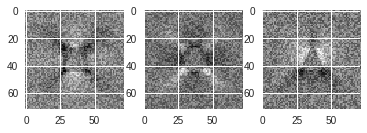

In [40]:
fig = plt.figure()
fig.add_subplot(1,3,1)
plt.imshow(weights_adam[:,0].reshape(72,72), cmap='gray')  # Rectangle
fig.add_subplot(1,3,2)
plt.imshow(weights_adam[:,1].reshape(72,72), cmap='gray')  # Disk
fig.add_subplot(1,3,3)
plt.imshow(weights_adam[:,2].reshape(72,72), cmap='gray')  # Triangle

In [0]:
# Visualize the rectangle
rectangle = df.iloc[:,0]
plt.imshow(rectangle.reshape(72,72), cmap='gray')

In [0]:
# Visualize the disk
disk = df.iloc[:,1]
plt.imshow(disk.reshape(72,72), cmap='gray')

In [0]:
# Visualize the triangle
triangle = df.iloc[:,2]
plt.imshow(triangle.reshape(72,72), cmap='gray')

# 5 - More difficult classification problem 

In [41]:
# Generate a new training set 
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [0]:
# one-hot encode target column 
target = to_categorical(Y_train)

# Input dimension 
n=X_train.shape[1]

## Linear model

In [0]:
# Model construction  with Adam optimizer
model_adam = Sequential()
model_adam.add(Dense(units=3, activation='softmax', input_shape= (n,)))
model_adam.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [45]:
hist = model_adam.fit(X_train, target, epochs=50,  validation_split = 0.25, batch_size = 32)

Train on 225 samples, validate on 75 samples
Epoch 1/50
225/225 [==============================] - 0s 1ms/step - loss: 2.1258 - acc: 0.3689 - val_loss: 3.2921 - val_acc: 0.2667
Epoch 2/50
225/225 [==============================] - 0s 229us/step - loss: 2.8992 - acc: 0.2889 - val_loss: 1.7297 - val_acc: 0.3467
Epoch 3/50
225/225 [==============================] - 0s 233us/step - loss: 1.4753 - acc: 0.3244 - val_loss: 1.1370 - val_acc: 0.4133
Epoch 4/50
225/225 [==============================] - 0s 230us/step - loss: 1.0124 - acc: 0.5156 - val_loss: 1.2103 - val_acc: 0.3200
Epoch 5/50
225/225 [==============================] - 0s 209us/step - loss: 1.1925 - acc: 0.4489 - val_loss: 1.2804 - val_acc: 0.5067
Epoch 6/50
225/225 [==============================] - 0s 233us/step - loss: 1.0374 - acc: 0.4800 - val_loss: 1.0646 - val_acc: 0.4000
Epoch 7/50
225/225 [==============================] - 0s 212us/step - loss: 1.1357 - acc: 0.4533 - val_loss: 1.4021 - val_acc: 0.4800
Epoch 8/50
225/225 

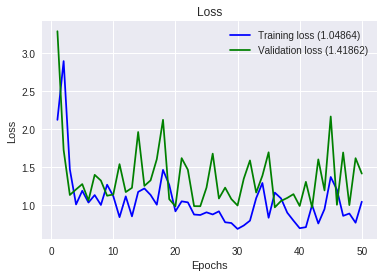

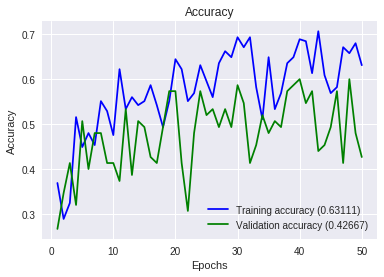

In [46]:
plot_history(hist)

In [47]:
# Generate test set 
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [0]:
model_adam.evaluate(X_test, Y_test, batch_size=32)

We have an accuracy less than in the previous part 

## Convolutional (not to) deep network



In [0]:
#reshape data to fit model
X_train = X_train.reshape(X_train.shape[0],72,72,1)
X_test = X_test.reshape(X_test.shape[0],72,72,1)


In [64]:
X_train.shape  , X_test.shape

((300, 72, 72, 1), (300, 72, 72, 1))

In [0]:
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

conv_model = Sequential()
#add model layers
conv_model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
conv_model.add(MaxPooling2D((2,2)))
conv_model.add(Flatten())
conv_model.add(Dense(units=3, activation ='softmax'))
conv_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [71]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 55491     
Total params: 55,907
Trainable params: 55,907
Non-trainable params: 0
_________________________________________________________________


In [72]:
hist = conv_model.fit(X_train, target, epochs=100,  validation_split = 0.25)

Train on 225 samples, validate on 75 samples
Epoch 1/100
225/225 [==============================] - 1s 3ms/step - loss: 1.5508 - acc: 0.2667 - val_loss: 1.2689 - val_acc: 0.5333
Epoch 2/100
225/225 [==============================] - 0s 446us/step - loss: 1.2338 - acc: 0.3733 - val_loss: 1.0369 - val_acc: 0.4667
Epoch 3/100
225/225 [==============================] - 0s 432us/step - loss: 0.9822 - acc: 0.4667 - val_loss: 1.0161 - val_acc: 0.4400
Epoch 4/100
225/225 [==============================] - 0s 426us/step - loss: 0.9313 - acc: 0.5378 - val_loss: 0.9573 - val_acc: 0.6000
Epoch 5/100
225/225 [==============================] - 0s 431us/step - loss: 0.8582 - acc: 0.6622 - val_loss: 0.9843 - val_acc: 0.5200
Epoch 6/100
225/225 [==============================] - 0s 447us/step - loss: 0.8081 - acc: 0.6800 - val_loss: 0.9167 - val_acc: 0.6267
Epoch 7/100
225/225 [==============================] - 0s 419us/step - loss: 0.7252 - acc: 0.7644 - val_loss: 0.9390 - val_acc: 0.5200
Epoch 8/100


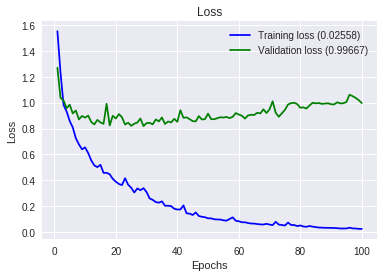

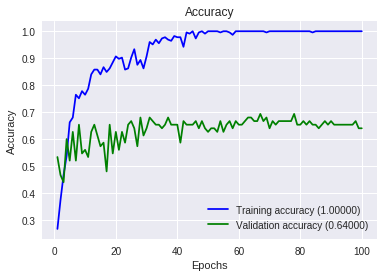

In [73]:
plot_history(hist)

In [74]:
conv_model.evaluate(X_test,Y_test)

300/300 [==============================] - 0s 228us/step


[0.930246213277181, 0.6799999992052714]

We have improved the accuracy of our model by adding other layers

#6 - Regression Problem

In [76]:
# Generate regression dataset
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


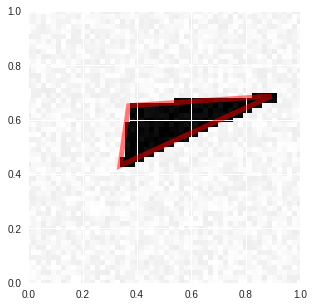

In [77]:
  visualize_prediction(X_train[0], Y_train[0])